# Generate a Noise Model using Calibration Data 

We will use pairs of noisy calibration observations $x_i$ and clean signal $s_i$ (created by averaging these noisy, calibration images) to estimate the conditional distribution $p(x_i|s_i)$. Histogram-based and Gaussian Mixture Model-based noise models are generated and saved. 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import torch
dtype = torch.float
device = torch.device("cuda:0") 
from torch.distributions import normal
import matplotlib.pyplot as plt, numpy as np, pickle
from scipy.stats import norm
from tifffile import imread
import sys
sys.path.append('../../../')
from pn2v import *
import pn2v.gaussianMixtureNoiseModel
import pn2v.histNoiseModel

### Download data

Download the data from https://cloud.mpi-cbg.de/index.php/s/BE8raMtHQlgLDF3/download. Here we show the pipeline for Convallaria dataset. Save the dataset in an appropriate path. For us, the path is the data folder which exists at `../../../`.

In [2]:
# Download data
import os
import urllib
import zipfile

if not os.path.isdir('../../../data'):
    os.mkdir('../../../data')

zipPath="../../../data/Convallaria_diaphragm.zip"
if not os.path.exists(zipPath):  
    data = urllib.request.urlretrieve('https://cloud.mpi-cbg.de/index.php/s/BE8raMtHQlgLDF3/download', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("../../../data")


The noise model is a characteristic of your camera. The downloaded data folder contains a set of calibration images (For the Convallaria dataset, it is ```20190726_tl_50um_500msec_wf_130EM_FD.tif``` and the data to be denoised is named ```20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif```). We can either bin the noisy - GT pairs (obtained from noisy calibration images) as a 2-D histogram or fit a GMM distribution to obtain a smooth, parametric description of the noise model.

### Specify ```path```, ```dataName```,  ```n_gaussian```, ```n_coeff```
Ensure that ```dataName``` is set same as in ```1_N2VTraining.ipynb```

In [3]:
path="../../../data/Convallaria_diaphragm/"
dataName = 'convallaria' # Name of the noise model 
n_gaussian = 3 # Number of gaussians to use for Gaussian Mixture Model
n_coeff = 2 # No. of polynomial coefficients for parameterizing the mean, standard deviation and weight of Gaussian components.

In [4]:
observation= imread(path+'20190726_tl_50um_500msec_wf_130EM_FD.tif') # Load the appropriate data
nameHistNoiseModel ='trained_HistNoiseModel_'+dataName+'_'+'calibration'
nameGMMNoiseModel = 'trained_GMMNoiseModel_'+dataName+'_'+str(n_gaussian)+'_'+str(n_coeff)+'_'+'calibration'

(1, 1024, 1024)


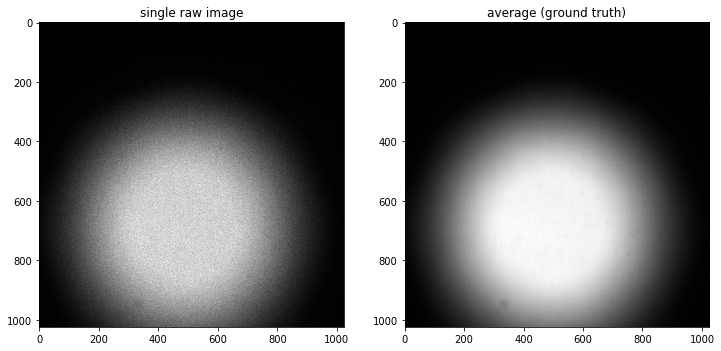

In [5]:
# The data contains 100 images of a static sample.
# We estimate the clean signal by averaging all images.

signal=np.mean(observation[:, ...],axis=0)[np.newaxis,...]

# Let's look the raw data and our pseudo ground truth signal
print(signal.shape)
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 2)
plt.title(label='average (ground truth)')
plt.imshow(signal[0],cmap='gray')
plt.subplot(1, 2, 1)
plt.title(label='single raw image')
plt.imshow(observation[0],cmap='gray')
plt.show()

### Creating the Histogram Noise Model

Using the raw pixels $x_i$, and our averaged GT $s_i$, we are now learning a histogram based noise model. It describes the distribution $p(x_i|s_i)$ for each $s_i$. 

In [6]:
# We set the range of values we want to cover with our model.
# The pixel intensities in the images you want to denoise have to lie within this range.
# The dataset is clipped to values between 0 and 255.
minVal, maxVal = 234, 7402
bins = 256

# We are creating the histogram.
# This can take a minute.
histogram = pn2v.histNoiseModel.createHistogram(bins, minVal, maxVal, observation,signal)

# Saving histogram to disc.
np.save(path+nameHistNoiseModel+'.npy', histogram)
histogramFD=histogram[0]

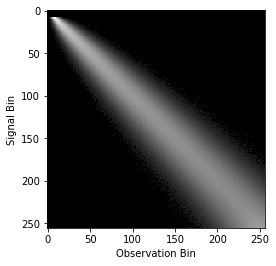

In [7]:
# Let's look at the histogram-based noise model.
plt.xlabel('Observation Bin')
plt.ylabel('Signal Bin')
plt.imshow(histogramFD**0.25, cmap='gray')
plt.show()

### Creating the GMM noise model
Using the raw pixels $x_i$, and our averaged GT $s_i$, we are now learning a GMM based noise model. It describes the distribution $p(x_i|s_i)$ for each $s_i$. 

In [8]:
min_signal=np.min(signal)
max_signal=np.max(signal)
print("Minimum Signal Intensity is", min_signal)
print("Maximum Signal Intensity is", max_signal)

Minimum Signal Intensity is 468.95
Maximum Signal Intensity is 32738.79


Iterating the noise model training for `n_epoch=2000` and `batchSize=250000` works the best for `Convallaria` dataset. 

In [9]:
gaussianMixtureNoiseModel = pn2v.gaussianMixtureNoiseModel.GaussianMixtureNoiseModel(min_signal, max_signal, path=path, weight = None, n_gaussian = n_gaussian, n_coeff = n_coeff)
gaussianMixtureNoiseModel.train(signal, observation, batchSize = 250000, n_epochs = 2000, learning_rate=0.1, name = nameGMMNoiseModel)

0 15.276237487792969
100 7.322710990905762
200 7.325920104980469
300 7.3260884284973145
400 7.320888996124268
500 7.326667785644531
600 7.328930854797363
700 7.318582057952881
800 7.319775104522705
900 7.319143772125244
1000 7.318779468536377
1100 7.314112186431885
1200 7.315104007720947
1300 7.31532621383667
1400 7.3163042068481445
1500 7.322647571563721
1600 7.317939758300781
1700 7.317042827606201
1800 7.325068473815918
1900 7.314417839050293


### Visualizing the Histogram-based and GMM-based noise models

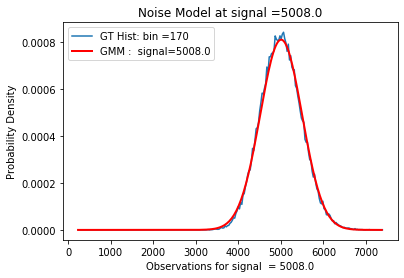

In [10]:
n_bin = 256
index= 170
min_signal=minVal
max_signal=maxVal
binclip=300
histBinSize=(max_signal-min_signal)/n_bin

querySignal_numpy= (index/float(n_bin)*(max_signal-min_signal)+min_signal)
querySignal_numpy+=histBinSize/2
querySignal_torch = torch.from_numpy(np.array(querySignal_numpy)).float().to(device)

idx = torch.from_numpy(np.arange(min_signal, max_signal, histBinSize)).float().to(device)
p=gaussianMixtureNoiseModel.likelihood(idx, querySignal_torch)
pNumpy=p.cpu().detach().numpy()

xvals=np.arange(n_bin)/float(n_bin)*(max_signal-min_signal)+min_signal
xvals+=histBinSize/2 


plt.plot(xvals[:binclip], histogramFD[index,:binclip]/histBinSize, label='GT Hist: bin ='+str(index))
plt.plot(np.arange(min_signal, max_signal,histBinSize)[:binclip], pNumpy[:binclip], label='GMM : '+' signal='+str(np.round(querySignal_numpy,2)),color='red',linewidth=2)
plt.xlabel('Observations for signal  = ' + str(querySignal_numpy))
plt.ylabel('Probability Density')
plt.title("Noise Model at signal =" + str(querySignal_numpy))
plt.legend()